In the previous [post](https://lucasvw.github.io/posts/13_ngram/) we had a first look at language models and discussed the n-gram model. Specifically, we:

- created a count based model
- created a neural network based model
- established an equivalence between both (hand-wavingly theoretical and emperical)
- discussed the curse of dimensionality and the sparse count matrix for n-grams with increasing values for n

In this post we are going to have a look at a neural network that is described in Bengio et al: [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) which aims to circumvent this curse of dimensionality by making use of embeddings.

This post is inspired by the [series](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ) from Andrej Karpathy's on neural networks.

## Data

Everything starts with training data, for a description see the previous [post](https://lucasvw.github.io/posts/13_ngram/)

In [ ]:
#| code-fold: true

import random
from functools import reduce, partial
from pathlib import Path
from urllib.request import urlretrieve
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torcheval.metrics as tem
import fastcore.all as fc

from nntrain.dataloaders import DataLoaders
from nntrain.learner import *
from nntrain.activations import *
from nntrain.acceleration import *
from nntrain.ngram import *

In [ ]:
########### Load the data ###########
path = Path('./data')
path.mkdir(parents=True, exist_ok=True)
path = path / 'names.txt'
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'

_ = urlretrieve(url, path)

with open(path, 'r') as f:
    lines = f.read().splitlines()
    
random.seed(42)
random.shuffle(lines)

### Create dictionary and mappings ###
unique_chars = list(set("".join(lines)))
unique_chars.sort()
dictionary = ['.'] + unique_chars

c2i = {c:i for i, c in enumerate(dictionary)}
i2c = {i:c for i, c in enumerate(dictionary)}

## Embeddings: relation to integer and one-hot encoding

In the previous post we introduced embeddings in the following way:

:::{.callout-embedding-layer}
An **embedding layer** is a layer that is used to "encode" our data, which roughly translates to the way we input our data into a neural network. We already saw above that we numericalized our characters (a-z) as integers. We will have to do something similar for our neural network, since we can't input characters into a neural network. However, instead of feeding integers into our network, we can also employ an embedding layer, which will basically create a vector out of our integers. Each integer value will be mapped to it's own vector, and the values contained in this vector will be learned during training. The advantage of this, is that the model can easily learn different "attributes" that make up the individual tokens. For example, it *could* use the first dimension in the vector to denote whether the token is a vowel (a, e, i, o, u) and the second dimension to represent the likelihood of starting a sentence. The emphasis in the last sentence is on *could*, since these things have to be learned by the network itself during the training-process.
:::

### Integer encoding
This is all well and good, but let's add some more detail and intuition. Let's go back to ultimate basics and see what happens if we feed numericalized tokens (integers) directly into a model using context length of 1, and a first linear layer consisting of 4 neurons (for simplicity we ignore the bias term). Since we have a context length of 1, one single sample consists of one value (the integer encoded value of our token) and is depicted in blue. We have 4 neurons, which weights are also just a single value, depicted in green. The activations of the 4 neurons are depicted in yellow.

![Matrix multiplication of one sample consisting of 1 token (blue matrix) with a 4 neuron linear layer (green matrix). On the bottom: the simple multiplication associated with the activation of the first neuron](mm2.png){width=300}

As you can see, the integer values are just being multiplied by the weights of the linear layer. This establishes an implicit relation between our inputs (blue matrix) in terms of the activation (yellow matrix). Consider a context *e* (numericalized 4) and another context *a* (numericalized 1). Because of the linearity, the activations of the former will always be 4 times as large as the activations of the latter. No matter how we change the weights in our network, this implicit relation will always be there, and there is no good reason why this should be the case. Moreover, the factor (4) is a result from the ordering of our dictionary. If instead we would have $a$ in 10<sup>th</sup> position, and $e$ in 20<sup>th</sup> position, the difference would have been a factor of 2. It should be clear that these kind of implicit linear relations don't fit to our (*nominal*) data, and should only be used for *ratio*, *interval* and possibly *ordinal* data.

### One-hot encoding

So how then should we treat these variables? If you are familiar with linear regression you have probably heard of *one hot encoding*. This is a technique in which we replace integer values with a vector. This vector will be of length equal to the amount of possible values the integer can take on and consists of zeros in all but one position, in that nonzero position the value will be `1`. Each integer will have this `1` in a different position. For a dictionary of length 4, the 4 vectors will be:

In [ ]:
for i in range(4):
    print(F.one_hot(torch.tensor(i), 4))

tensor([1, 0, 0, 0])
tensor([0, 1, 0, 0])
tensor([0, 0, 1, 0])
tensor([0, 0, 0, 1])


So we have turned our single integer variable, into 4 distinct (binary) variables. Each of these 4 variables will have it's own associated weight (parameter) in linear regression and the contributions to the output are thus totally independant of another. To see this, let's assume we fit a linear function: $y = b \cdot x$ where $x$ is an integer variable taking on 4 values and is transformed into 4 binary variables as shown above $z_1, .. ,  z_4$. We then have:

\begin{align}
y &= b_1 z_1 + b_2 z_2 + b_3 z_3 + b_4 z_4  \\
y &= \left.
  \begin{cases}
    b_1, & \text{for } x = 1 (z_1 = 1, z_2 = 0, z_3 = 0, z_4 = 0) \\
    b_2, & \text{for } x = 2 (z_1 = 0, z_2 = 1, z_3 = 0, z_4 = 0) \\
    b_3, & \text{for } x = 3 (z_1 = 0, z_2 = 0, z_3 = 1, z_4 = 0) \\
    b_4, & \text{for } x = 4 (z_1 = 0, z_2 = 0, z_3 = 0, z_4 = 1) \\
  \end{cases}
  \right\}
\end{align}

Since $b_1$ through $b_4$ can take on any value during fitting, we got rid of our implicit relation between our tokens!

### Embedding encoding

For a neural network, something very similar happens. Here an example when we feed these 4 vectors into a linear layer consisting of **2 neurons**:

In [ ]:
#| code-fold: true

integer_value = 0
one_hot = F.one_hot(torch.tensor(integer_value), 4).to(torch.float32)
linear = torch.rand(4,2)

print(f'{"integer value":<25}: {integer_value}')
print(f'{"one hot representation":<25}: {one_hot.tolist()}')
print('weight matrix of linear layer:')
print(linear)
print('activations of one hot encoded vector of integer "0" with linear layer:')
print(one_hot@linear)

integer value            : 0
one hot representation   : [1.0, 0.0, 0.0, 0.0]
weight matrix of linear layer:
tensor([[0.1354, 0.9329],
        [0.0975, 0.1335],
        [0.4640, 0.6912],
        [0.3926, 0.5246]])
activations of one hot encoded vector of integer "0" with linear layer:
tensor([0.1354, 0.9329])


So the activations are just the weights associated with the first input to both neurons! If you are familiar with the drawing of neural networks as connected neurons, the activations are equal to the highlighted weights in the drawing below:

![The highlighted weights that get pulled out of the weight matrix for a one-hot representation of integer `0`](./mm3.png)


We conclude: **multiplying a one-hot encoded vector with a weight matrix, simply returns the weights of the associated row of that weight matrix**.

Mathematically this is thus equivalent to indexing into the weight matrix at the row equal to the integer value:

In [ ]:
linear[integer_value]

tensor([0.1354, 0.9329])

If we compare now the inputs (integer values) with the outputs (vector of floats), we have verified the statement we made earlier: *However, instead of feeding integers into our network, we can also employ an embedding layer, which will basically create a vector out of our integers*.

And now let's also do this explicitly with an `nn.Embedding` layer:

In [ ]:
emb = nn.Embedding(4, 2)
print('weight matrix of embedding layer:')
print(emb.weight.data); print('\n')
print('activations of embedding layer of integer "0":')
print(emb(torch.tensor(integer_value)).data)

weight matrix of embedding layer:
tensor([[-0.5065, -0.5940],
        [-0.9815, -0.3719],
        [-1.2932, -1.1999],
        [ 0.3102,  0.2803]])


activations of embedding layer of integer "0":
tensor([-0.5065, -0.5940])


Since the parameters of this layer are learned through backpropagation, Bengio et al refer to this as *learning a distributed representation for words* (in our case we use it for *characters* instead of *words*, but the idea is the same). The distributed representation (in the example above a vector of length 2), is what we previously referred to as the different *attributes* the model can learn that are associated with the tokens.

## Embeddings: mapping inputs into n-dimensional space

These different *attributes* is also what we refer to when saying that embedding layers *map inputs into an n-dimensional space*. With n being the amount of attributes, generally smaller then the size of the dictionary. For example, if we would create an embedding layer with depth of (number of *attributes*) 4 we would have:

- integer encoded tokens: 1D (27 possible values)
- one-hot encoding: 27D (binary values: either zero or one)
- embedding: 4D (real / float valued)

And because the weights are learned, the model can place our inputs into this 4D space in positions it finds useful (for learning the task at hand, that is). Inputs that are similar can be placed closely together, and input that are very different can be placed further apart. Moreover, since this space can (and generally is) high dimensional, it can place inputs close together on certain dimensions, but far apart in other dimensions. This allows for a differentiated representation of our inputs, where on some *attributes* inputs might be similar, but on other *attributes* very different.

## Embeddings: the key to generalization

A final intuition I would like to share, has to do with being "out of distribution". Let's say during training you have encountered the sentences (for this example we switch to sentences and words, instead of names and characters):

- a dog is walking through the kitchen
- a dog is walking through the living room
- a dog is walking through the garden

But never a similar sentence for a cat. If an n-gram ($n >= 6$) model has to fill in the next word in the sequence: "a cat is walking through the ..." it wouldn't know what to reply, because we are *out of distribution*: during training we never encountered such a context so it has nothing to go on. The learned probability distribution of an n-gram model is only possible when the model has seen examples of the exact context (possibly with different labels, which are the basis for the *probability distribution*).

However, for a model using a learned distributed representation, we ideally would like the model to be able to use it's knowledge of cats being similar to dogs, and thus use the training data it has seen on dogs to be able to answer: *kitchen*, *living room* or *garden*. This kind of generalization becomes possible with embeddings since the model can learn that the vector for cats is similar to the vector for dogs. 

This similarity in vector space, will lead to similar outputs. In the words of Bengio et al:

*"In the proposed model, it will so generalize because “similar” words are expected to have a similar feature vector, and because the probability function is a smooth function of these feature values, a small change in the features will induce a small change in the
probability. Therefore, the presence of only one of the above sentences in the training data will increase the probability, not only of that sentence, but also of its combinatorial number of “neighbors” in sentence space (as represented by sequences of feature vectors)"*.

## Using Embeddings effectively

Now that we have a better understanding of embeddings both mathematically and conceptually, let's turn to the paper of Bengio et al. Where they make smart use of embeddings to circumvent the problems with huge weight matrices for n-grams with large n.

The following (simplified) architecture diagram is from that paper and describes pretty well what's going on.

On the bottom we see three inputs, so we are using a context of length 3. These inputs are feeded into *the same* embedding layer C. Also, this embedding layer as a depth *smaller then the size of the dictionary* 

:::{.callout-note}
For the n-gram neural network model we actually also used an embedding layer, but it has a depth equal to the size of the dictionary. We were thus mapping our integers into a 27D space, you can imagine that with just 27 integers that space was super sparse!
:::

For an n-gram model we would have already $27^3$ parameters to accomodate all the different possibilities in the context. However, here we just have `dictionary length x embedding depth` parameters. Since all the elements of the context are feed through the same embedding layer, it's not dependant on the context length, which allows us to increase the context length without having a penalty on the amount of parameters. This implicitly means, *that the position of the token is ignored as far as the embedding layer is concerned*. That is, a letter *e* in first or second position will give the same embedding activation.

Next, the three embedding vectors are concatenated and passed through a hidden linear layer with a tanh activation function. This is thus where the *positional information* is dealt with in this model. 

Finally the activations get passed through another linear layer, which maps the activations to the correct amount of classes (i.e. the number of tokens in the dictionary).

![](arch.png){width=600}

Let's build this model and train it with `nntrain`:

In [ ]:
# Datasets and loaders

train_size=0.8
val_size=0.1

train_lines = lines[0:int(train_size * len(lines))]
val_lines = lines[int(train_size * len(lines)): int((train_size + val_size) * len(lines))]

train_ds = NgramDataset(train_lines, c2i, n=4)
val_ds = NgramDataset(val_lines, c2i, n=4)

bs = 1000
train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=bs, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bs*2, num_workers=4)
dls = DataLoaders(train_loader, val_loader)

As a reminder, let's have a look at the samples for the first name in the dataset ("Yuheng")

In [ ]:
xb, yb = train_ds[0:6]
for x,y in zip(xb, yb):
    print(list(i2c[i.item()] for i in x), '-->' ,i2c[y.item()])

['.', '.', '.'] --> y
['.', '.', 'y'] --> u
['.', 'y', 'u'] --> h
['y', 'u', 'h'] --> e
['u', 'h', 'e'] --> n
['h', 'e', 'n'] --> g


In [ ]:
class MLP(nn.Module):
    def __init__(self, c2i, emb_dim, ctx_len, n_hidden):
        super().__init__()
        self.ctx_len = ctx_len
        self.emb    = nn.Embedding(len(c2i), emb_dim)
        self.hidden = nn.Linear(emb_dim*ctx_len, n_hidden)
        self.tanh   = nn.Tanh()
        self.out    = nn.Linear(n_hidden, len(c2i))
        
    def forward(self, x):
        out = self.emb(x)
        out = out.view(out.shape[0], -1)
        out = self.hidden(out)
        out = self.tanh(out)
        out = self.out(out)
        return out

Let's find a good learning rate:

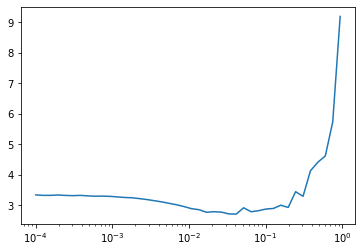

In [ ]:
mlp = MLP(c2i, emb_dim=2, ctx_len=3, n_hidden=50)

subs = [DeviceS(device)]

lrfind = LRFindS()
l = Learner(mlp, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs + [lrfind])
l.fit(5, lr=1e-4)
lrfind.plot()

Let's take a learning rate of `3e-2`, and use the `OneCycleLR` scheduler together with an `Adam` optimizer:

epoch,mode,loss
0,train,2.697
0,eval,2.444
1,train,2.395
1,eval,2.358
2,train,2.336
2,eval,2.312
3,train,2.304
3,eval,2.288
4,train,2.285
4,eval,2.280


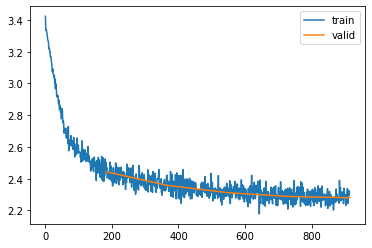

In [ ]:
epochs = 5
N = len(train_loader)
lr = 3e-2

mlp = MLP(c2i, emb_dim=2, ctx_len=3, n_hidden=50)

sch = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=N)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device)]

l = Learner(mlp, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(sch)])
l.fit(epochs, lr=lr)

Next, let's see if we can tweak the hyperparameters to get the best performance. Below I show the result of trying for around 10 minutes to get the best results:

In [ ]:
def get_dls(bs, context_length):
    train_ds = NgramDataset(train_lines, c2i, n=context_length+1)
    val_ds = NgramDataset(val_lines, c2i, n=context_length+1)
    train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=bs, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bs*2, num_workers=4)
    dls = DataLoaders(train_loader, val_loader)
    return dls

epoch,mode,loss
0,train,2.405
0,eval,2.284
1,train,2.254
1,eval,2.238
2,train,2.150
2,eval,2.104
3,train,2.011
3,eval,2.022
4,train,1.890
4,eval,1.990


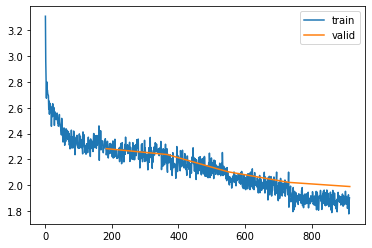

In [ ]:
# Train parameters
epochs = 5
lr     = 3e-2
bs     = 1000

# Hyperparameters
context_length = 15
nh             = 350
emb_dim        = 20

dls = get_dls(bs, context_length)
mlp = MLP(c2i, emb_dim, context_length, nh)
scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(mlp, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

And this is looking pretty good. The loss we obtained from n-gram models are around 2.139, with this model we are around 2.

## Tanh activation function

The MLP model we have used, is employing a tanh activation function which we haven't encountered so far. So let's have a quick look at it:

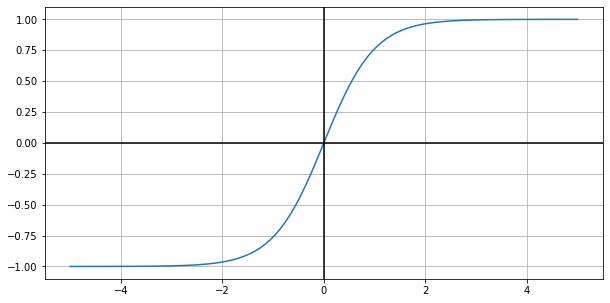

In [ ]:
x = np.linspace(-5,5,100)
y = np.tanh(x)

fig, axs = plt.subplots(1,1, figsize=(10,5))
axs.plot(x,y);
axs.grid();
axs.axhline(0, c='black');
axs.axvline(0, c='black');

Observe that the tanh activation function has y limits at -1 and 1: however large or small the input, the output is always between -1 and 1. These asymptotes are very flat, meaning that the derivatives in these areas are extremely small. Thinking back at the learning mechanism of neural networks, and remembering that gradients are flowing back through the network by making use of the chain rule: having very small local gradients of a tanh activation function leads to the cancelling-out of whatever gradient has been accumulated so far. This means that the weight updates of all upstream weights is impacted. Previously, this behavior was mentioned in terms of the ReLU activation function, see [here](https://lucasvw.github.io/posts/11_nntrain_activations/#activations).

This becomes a serious problem, if for all our data (in a batch, or even worse in an epoch) this is the case. So let's check how we are doing by creating a [`ActivationStatsS`](https://github.com/lucasvw/nntrain/blob/main/nntrain/activations.py#L39) subclass tailored towards tracking stats for the tanh activation.

In [ ]:
class TanhActivationS(ActivationStatsS):
    
    def record_stats(self, learn, hook, layer, inp, outp):
        if learn.model.training:
            if not hasattr(hook, 'stats'): hook.stats = ([], [])
            acts = outp.detach().cpu()
            hook.stats[0].append(acts.histc(100,-1,1))           # get the histogram counts with 100 bins in the range (-1,1)
            
            # computation of the not_firing_rate_per_act
            N = acts.shape[0]                 
            flat = acts.view(N, -1)                              # flatten the activations: matrix of [samples, activations]
            nf_rate_p_act = (flat.abs() > 0.99).sum(dim=0) / N   # compute not firing rate per activations (so across the samples)
            hook.stats[1].append(nf_rate_p_act)   

epoch,mode,loss
0,train,2.383
0,eval,2.262
1,train,2.257
1,eval,2.232
2,train,2.150
2,eval,2.126
3,train,2.015
3,eval,2.035
4,train,1.902
4,eval,1.997


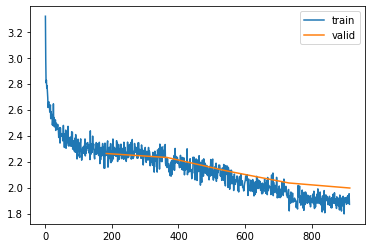

In [ ]:
# Train parameters
epochs = 5
lr     = 3e-2
bs     = 1000

# Hyperparameters
context_length = 15
nh             = 350
emb_dim        = 20

dls = get_dls(bs, context_length)
mlp = MLP(c2i, emb_dim, context_length, nh)
scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))
tanhS = TanhActivationS([m for m in mlp.modules() if isinstance(m, nn.Tanh)])

l = Learner(mlp, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)] + [tanhS])
l.fit(epochs, lr=lr)

And, let's now plot all histograms of the activations during training as a heatmap:

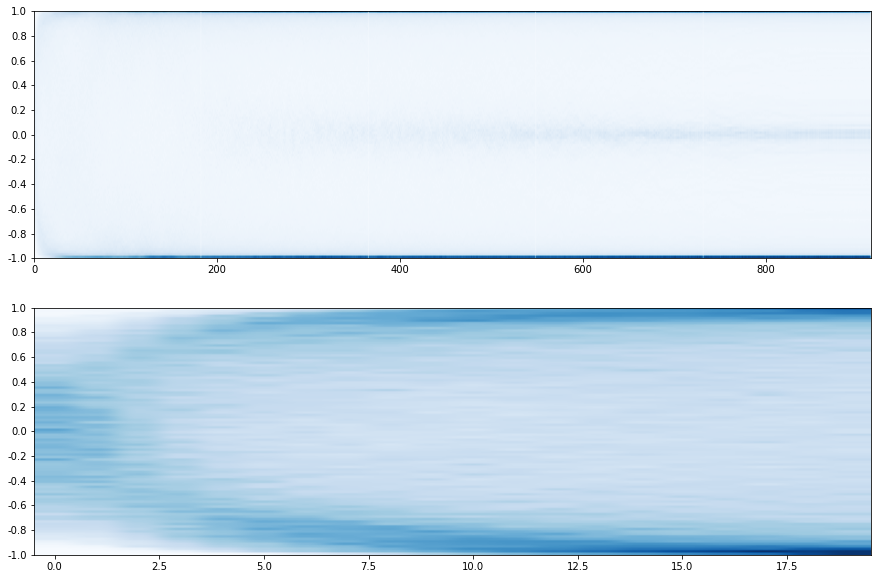

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(15,10))

hist = torch.stack(tanhS.hooks[0].stats[0]).T
ax[0].imshow(hist, cmap='Blues', origin='lower', aspect='auto')
ax[0].set_yticks(np.arange(-0.5, 100.5, 10), [round(i, 1) for i in np.linspace(-1, 1, 11)]);
ax[1].imshow(hist[:,:20], cmap='Blues', origin='lower', aspect='auto')
ax[1].set_yticks(np.arange(-0.5, 100.5, 10), [round(i, 1) for i in np.linspace(-1, 1, 11)]);

On the top, the histograms are shown for all of training (800+ batches), and on the bottom the histograms for the first 20 batches are shown. We observe that during the beginning of training, we don't have over-saturated tanh activations, but as training progresses the activations become more and more saturated. We can also look at the dead rate per neuron: which is the amount of activations with absolute value > 0.99 across a batch per neuron:

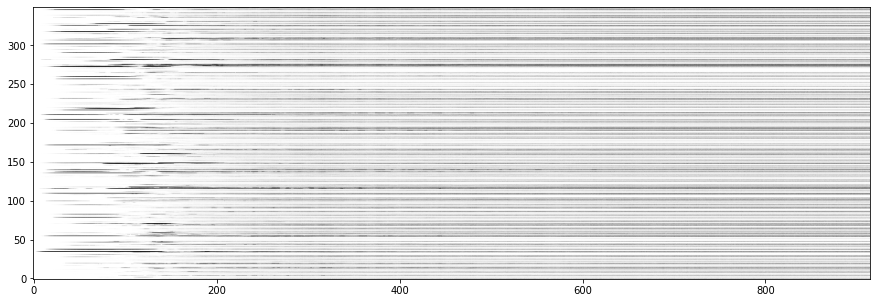

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

dead_rate = torch.stack(tanhS.hooks[0].stats[1]).T
ax.imshow(dead_rate, cmap='Greys', origin='lower', aspect='auto');

However, this doesn't seem to be problematic. Foremost, we need to make sure that we don't initialize in a way that causes over-saturated tanh activations. And as mentioned, during the beginning of training, this is not the case. Also, when looking at a histogram of the dead rate per neuron across the very last training batch we see that most neurons have a low dead-rate, and we don't have any neuron for which the dead-rate is higher then 75%:

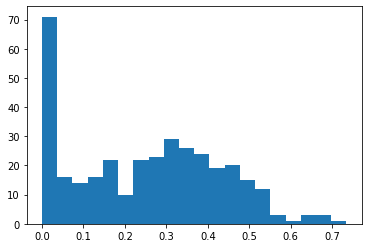

In [ ]:
plt.hist(dead_rate[:,-1], bins=20);

## Sampling names

To conclude, let's sample from this model:

In [ ]:
@fc.patch
def generate(self:MLP, n=10, generator=None):
    names = []
    for i in range(n):
        name = '.' * (self.ctx_len)
        while True:
            idx = torch.tensor([[c2i[i] for i in name[-(self.ctx_len):]]]).cuda()
            logits = self.forward(idx)
            s = torch.multinomial(F.softmax(logits, dim=1), 1, generator=generator)
            c = i2c[s.item()]
            name += c
            if c == '.':
                names.append(name)
                break
    return names

In [ ]:
names = mlp.generate()
[name[15:-1] for name in names]

['xenleigh',
 'samyah',
 'milena',
 'camrihan',
 'nafraya',
 'aris',
 'marcely',
 'zopierah',
 'serg',
 'oshem']

And these neural utterings are starting to sound pretty name-like!